# Simple Linear Model

En este .ipynb volveremos sobre un modelo lineal simple similar al tratado en los dos notebooks presentados en el artículo Deep Learning con Python: Introducción a TensorFlow (Parte II). 
Como entrada al modelo haremos uso del famoso MNIST dataset, formado por un conjunto de dígitos escritos a mano.

Nuestro modelo deberá ser capaz de estimar de qué número se trata, por lo que nos encontramos ante un claro ejemplo de clasificación.

In [1]:
# Importamos las librerías a las que vamos a recurrir en este cuaderno.

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

Como en todos los cuadernos de esta serie, se está trabajando con una versión de Python 3.5.2 (Anaconda) y con una versión de TensorFlow:

In [2]:
tf.__version__

'1.2.1'

## Obtención de los datos

El MNIST data-set que vamos a usar ocupa aproximadamente 12 MB y se descargará automáticamente desde los tutoriales de ejemplo de TensorFlow.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot = True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


Ya tenemos el MNIST data-set, que está compuesto por 70.000 imágenes, cada una con su correspondiente etiqueta (label). El data-set está partido en los sets de entrenamiento, testeo y validación.

In [4]:
print("Tamaño del:")
print("- Training-set:\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Tamaño del:
- Training-set:	55000
- Test-set:		10000
- Validation-set:	5000


### One-Hot Encoding

Se ha escogido la opción de cargar el data-set con la opción de One-Hot encoding. Esto significa que la etiqueta de cada imagen se ha convertido de un número a un vector cuya longitud equivale al número de clases posibles. Para una determinada etiqueta correspondiente a un número i, nos encontramos con que todos los elementos de ese array son 0 salvo el elemento i-ésimo, que se deja como un 1. Por ejemplo, para las primeras 3 imágenes del test data-set:

In [5]:
# Ejemplos de One-Hot encoded label
data.test.labels[0:3, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

Considerando que los números del dataset son los enteros hasta el 9 más el 0, tenemos un 7, un 2 y un 1 respectivamente.

También vamos a necesitar las clases como enteros, no como array, para poder medir la calidad de las predicciones de nuestro modelo. Es prácticamente inmediato convertir los vectores One-Hot encoded a números tomando el índice del elemento mayor de ese array.

In [6]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [7]:
data.test.cls[0:3]

array([7, 2, 1])

### Dimensionalidad de los datos

In [8]:
# Las imágenes de MNIST son de 28 x 28 píxeles
img_size = 28

# Haremos un resizing/flattening de las imágenes a arrays de tamaño 28 * 28
img_size_flat = img_size * img_size

# La dimensionalidad de las imágenes se puede expresar como:
img_shape = (img_size, img_size)

# El número de clases con el que vamos a trabajar es 10, uno por cada dígito del 0 al 9
num_classes = 10

### Función para representación de las imágenes del dataset

A continuación, definimos una función auxiliar para la respresentación en un grid `3 x 3` de 9 imágenes, que incluya tanto la clase verdadera como la predicha.

In [9]:
def plot_images(images, cls_true, cls_pred = None):
    # Verificamos que la longitud del contenedor de imágenes coincide con el número de clases 
    assert len(images) == len(cls_true) == 9
    
    # Se genera la figura con 9 subplots en estructura 3 x 3.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Se representan las imágenes.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Incluimos como xlabel para cada subplot la clase verdadera y la predicha.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Eliminamos los ticks de los ejes (detalle cosmético)
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

### Representación de algunas imágenes 

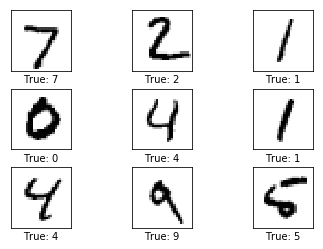

In [10]:
# Tomamos las primeras 9 imágenes del test data-set.
images = data.test.images[0:9]

# Alamcenamos en cls_true la verdadera clase de cada una de las imágenes.
cls_true = data.test.cls[0:9]

# Representamos en base a la función definida arriba. 
# De momento no contamos con clases predichas, así que mantenemos cls_pred = None.
plot_images(images=images, cls_true=cls_true)

## Definición de variables en TensorFlow

Debemos definir mediante Placeholders las variables que sirvan como input a nuestro grafo del modelo. 
Para cada imagen que incluyamos en el modelo definimos una variable placeholder de tamaño `img_size_flat = img_size * img_size`: 

In [11]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

También creamos una variable placeholder para las clases verdaderas asociadas a cada imagen que se introduzca en el placeholder `x`. La definimos con un tamaño `[None, num_classes]`, lo que significa que puede albergar un número arbitrario de etiquetas de tamaño `num_classes`, que es 10 en el caso que nos ocupa.

In [12]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

Por último, creamos una variable placeholder para la clase en forma de entero. Para ello, elegimo como `dtype = tf.int64` y como dimensión un vector unidimensional de tamaño indefinido `[None]`.

In [13]:
y_true_cls = tf.placeholder(tf.int64, [None])

### Variables a optimizar durante el entrenamiento

También necesitamos definir las variables relativas a la arquitectura que van a optimizarse durante el entrenamiento del modelos. Estas variables son dos: los pesos y los biases.

Los pesos deben definirse como un tensor bidimensional de dimensión `[img_size_flat, num_classes]`, mientras que los biases deben ser una matriz de dimensión `[num_classes]`.

Definimos ambas variables al inicio como un conjunto de ceros con la dimensionalidad indicada.

In [14]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

In [15]:
biases = tf.Variable(tf.zeros([num_classes]))

### Definición del modelo

Nuestro modelo simplemente debe hacer la multiplicación de la variable de entrada `x` con los `weights` y luego sumarle la variable `bias`. 

Llamaremos `logits` a ese conjunto de operaciones:

In [16]:
logits = tf.matmul(x, weights) + biases

In [17]:
logits

<tf.Tensor 'add:0' shape=(?, 10) dtype=float32>

`logits` es una matriz con un número de filas `? = num_images` y un número de columnas `num_classes = 10`. Con esto estamos obteniendo la predicción de un One-Hot encoded label.

Para obtener en el rango esperado la clase predicha, normalizamos el output de nuestro modelo usando la función softmax:


In [18]:
y_pred = tf.nn.softmax(logits)

Y es inmediato calcular la matriz de clases en forma de enteros recurriendo a `tf.argmax()`:

In [19]:
y_pred_cls = tf.argmax(y_pred, axis=1)

### Función de coste para la optimización

Optimizar los `weights` y `biases` del modelo dada la natrualeza de las entradas al modelo no es trivial. Necesitamos saber cómo de bueno es nuestro modelo prediciendo el valor de `y_pred` tomando como referencia `y_true`.

La cross-entropy es una medida de rendimiento ampliamente utilizada en la clasificación, siendo una función continua siempre positiva. Si la salida pronosticada del modelo coincide exactamente con la salida deseada, esta cross-entropy es igual a cero. Nuestro objetivo a la hora de optimizar es, por lo tanto, minimizar esa cross-entropy para que se acerque lo más posible a cero.

TensorFlow tiene una función incorporada para calcular esta función. Hay que tener cuidado, aquí usaremos directamente los valores de `logits`; esta función incorpora su `tf.softmax` internamente.

In [20]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits,
                                                        labels = y_true)

Ahora, la función de coste está dirigida a minimizar la cross-entropy:

In [21]:
cost = tf.reduce_mean(cross_entropy)

### Método de optimización

Tras haber definido una función que nos mida la bondad de nuestro ajuste y una función que nos permita qué tipo de minimización de esa función buscamos, ahora podemos crear un optimizador. Elegimos Gradient Descent con una learning rate relativamente elevada (0.5). 

Nótese que la optimización no comienza en este punto. Lo único que hemos hecho es añadir un elemento optimizador al grafo de TensorFlow para una posterior ejecución.

In [22]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

### Monitorización del rendimiento

Sería conveniente tener alguna herramienta para medir el rendiemiento del entrenamiento.

Definimos un vector de booleanos en función de si la clase predicha es igual a la clase esperada para cada imagen. Aqué es donde le sacamos partido a la definición de las clases como resultado de hacer `tf.argmax()` sobre las One-Hot encoded labels.

In [23]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

La precisión de la clasificación se puede aproximar como la media de las correctas predicciones. Recurrimos a `tf.cast( , tf.float32)` para poder ejecutar correctamente `tf.reduce_mean()`.

In [24]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Ejecución del entrenamiento con TensorFlow

### Creación de una sesión

Ya tenemos el grafo creado en TensorFlow. Ahora podemos crear una sesión para su posterior ejecución.

In [25]:
session = tf.Session()

### ¡Debemos inicializar variables!

Todo aquel elemento que se haya definido anteriormente como tf.Variable() debe inicializarse. En nuestro caso esto se corresponde con `weights` y `biases`

In [26]:
init = tf.global_variables_initializer()

In [27]:
session.run(init)

### Función auxiliar para optimizar mediante iteraciones (batches)

Contamos con 50.000 imágenes para entrenar el modelo. Como hicimos en anteriores ajustes lineales, emplearemos Stochastic Gradient Descent, que hará uso de de un reducido número de imágenes. Esta cantidad la definimos nosotros:

In [28]:
batch_size = 100

La siguiente función realiza, para cada batch de datos del training set, una optimización del modelo. De esta manera, se refinan los valores de `weights` y `biases`.

In [39]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # Elige un batch para el entrenamiento.
        # x_batch es un batch de imágenes y
        # y_true_batch son las etiquetas verdaderas de esas imágenes.
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # Creamos un feed_dict con las variables placeholder 
        # definidas en el grafo. El placeholder y_true_cls no 
        # se especifica en el feed_dict porque no se usa 
        # durante el entrenamiento, sino
        # durante la evaluación.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Ejecutamos la sesión llamando al optimizador 
        # para cada batch de datos de training-set.
        # TensorFlow asigna las variables en feed_dict_train
        # a las variables placeholder y ejecuta el optimizador
        session.run(optimizer, feed_dict=feed_dict_train)
        
        # sess.graph contiene la definición del grafo. Con esto habilitaremos el Graph Visualizer en tensorboard.
        # Desde un terminal seremos capaces de lanzar tensorboard. Las instrucciones quedan indicadas después de 
        # este notebook.
        graph_log = tf.summary.FileWriter("log/MNIST/", session.graph)

### Funciones auxiliares para monitorizar la bondad del modelo

Para evaluar el modelo creamos un feed dictionary que contenga el test data-set y las clases verdaderas tanto en forma de One-Hot encoder como en su formato argmax.

In [40]:
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}

Recurrimos a la expresión `accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))` antes dada.

In [41]:
def print_accuracy():
    # Ejecuta una sesión para calcular la accuracy de nuestro test data-set
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Muestra la precisión
    print("Precisión del test-set: {0:.1%}".format(acc))

Llamando a la librería scikit-learn, generamos la matriz de confusión.

In [42]:
def print_confusion_matrix():
    # Almacenamos las clases verdaderas de testeo en una variable
    cls_true = data.test.cls
    
    # Obtenemos las clasificaciones predichas para el test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # generamos la matriz de confusión
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Hacemos un print de la matriz de confusión
    print(cm)

    # Representamos la matriz
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Modificaciones cosméticas de la gráfica
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Representación de la gráfica
    plt.show()

A continuación, se muestra una función para representar una muestra de imágenes del test set que se han clasificado incorrectamente.

In [43]:
def plot_example_errors():
    # 
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)
    #
    incorrect = (correct == False)
    
    # Tomamos las imágenes mal clasificadas
    images = data.test.images[incorrect]
    
    # Las clases predichas para esas imágenes son:
    cls_pred = cls_pred[incorrect]

    # Las clases esperadas para las imágenes 
    # incorrrectamente clasificadas
    cls_true = data.test.cls[incorrect]
    
    # Representamos las primeras 9 imágenes mal clasificadas
    # recurriendo a nuestra primera función auxiliar
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Función auxiliar para la representación de los pesos `weights` del modelo

Se representan 10 imágenes, uno por cada dígito al que hemos enseñado a nuestro modelo a reconocer. 

In [44]:
def plot_weights():
    # Obtenemos los pesos del modelo, entendidos como una variable TensorFlow.
    w = session.run(weights)
    
    # Se toman los valores máximos y mínimos de los pesos
    # como referencia para corregir la intensidad del 
    # color en la representación y poder hacer comparaciones
    # entre pesos.
    w_min = np.min(w)
    w_max = np.max(w)

    # Creamos un subplot 3x4,
    # los últimos 2 sub-plots quedarán vacíos.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Sólo usar los pesos para los primeros 10 subplots.
        if i < 10:
            # A la imagen se le hace un reshape a img_shape x img_shape
            # Ahora mismo w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Indicamos la clase de cada sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Representamos la imagen
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Eliminamos los ticks de cada subplot
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Representación de la gráfica
    plt.show()

## Comportamiento del modelo antes de iniciar optimización

La precisión devuelta por la evaluación del test-set es muy baja ahora mismo. El modelo todavía no ha sifo optimizado, por lo que siempre predice que las im-agenes son un cero. Por eso obtenemos un 9.8% de accuracy. en nuestros test-set ese es el porcentaje verdadero de muestras que son un cero.

In [45]:
print_accuracy()

Precisión del test-set: 49.8%


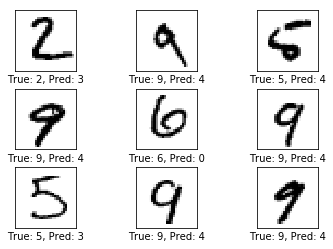

In [46]:
# En este punto, nuestro modelo no acierta a clasificar ni una de las imágenes.
plot_example_errors()

## Comportamiento del modelo tras 1 iteración

Tras una iteración de optimización del modelo a lo largo de todo el training data-set, la precisión del test set debería aumentar.

In [47]:
optimize(num_iterations = 1)

In [48]:
acc = print_accuracy()

Precisión del test-set: 59.0%


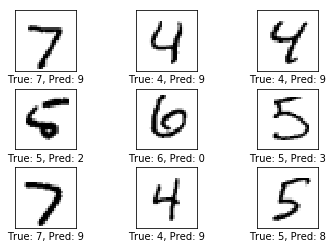

In [49]:
plot_example_errors()

Tras una sola iteración, la precisión ha aumentado significativamente. Como vemos, nuestro modelo ha dejado de clasificar todos los números como un 0. Algunos de los errores que comete nuestro modelo, son entendibles. 


Podemos representar los pesos de nuestro modelo mediante la función `plot_weights()`. Es significativo ver cómo, tras una sola iteración, las formas más características de los números empiezan a esbozarse.

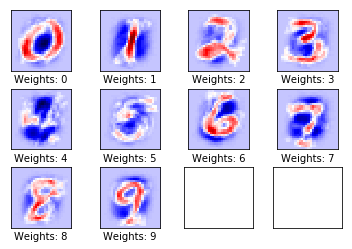

In [51]:
plot_weights()

## Comportamiento del modelo tras 10 iteraciones

In [52]:
# Como ya hemos realizado 1 iteración, realizamos 9 iteraciones más.
optimize(num_iterations = 9)

In [53]:
print_accuracy()

Precisión del test-set: 73.9%


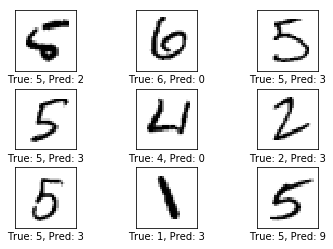

In [55]:
# Representamos algunos de los ejemplos del test-set cuya clasificación ha fallado. 
plot_example_errors()

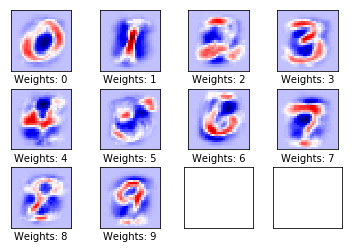

In [56]:
plot_weights()

## Comportamiento del modelo tras 1000 iteraciones

Después de 1.0e+03 iteraciones de optimización, el modelo es capaz de acertar aproximadamente 9 de cada 10 imágenes. Algunos de los fallos están justificados, pues algunos números estań mal escritos y se prestan a confusión. Por otro lado, hay otros que resultan obvios y que nuestro modelo no puede clasificar. Este modelo lineal no permite precisiones sustancialmente mejores, por eso se recurren a otros enfoques y arquitecturas que se mencionarán posteriormente.

In [57]:
# Realizamos 990 iteraciones más, pues ya tenemos hechas 10
optimize(num_iterations=990)

In [58]:
print_accuracy()

Precisión del test-set: 91.9%


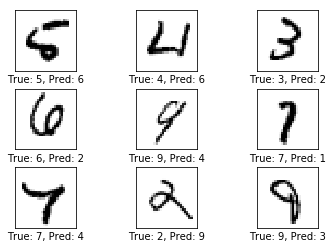

In [60]:
plot_example_errors()

Nuestro modelo ha sido entrenado a lo largo de 1.0e+03 iteraciones, tomando en cada iteración 100 imágenes del training set. Debido a la gran variedad de imágenes, ahora los pesos se hacen mucho más difícil de interpretar. La abstracción de los mismos ha aumentado, y podemos ver cómo sólo se resaltan algunas partes o segmentos de los números.  

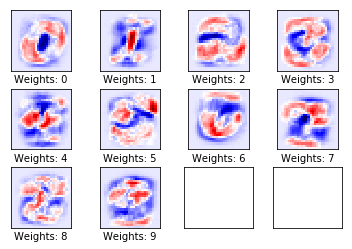

In [61]:
plot_weights()

Podemos echarle un vistazo también a la matriz de confusión, ya que nos dará algunos detalles sobre los errores de clasificación observados. Por ejemplo, parece que el número que más le cuesta a nuestro modelo identificar es el 5, que puede confundirse con el 3 o el 8.  

[[ 957    0    3    2    0    7    8    1    2    0]
 [   0 1110    2    2    0    2    4    2   13    0]
 [   7    7  932   12   11    4    8   10   36    5]
 [   3    1   26  893    0   53    1   10   14    9]
 [   1    4   10    1  915    1    7    2    9   32]
 [   8    4    5   24    7  800   10    4   23    7]
 [  10    3    9    1   10   24  896    1    4    0]
 [   3   14   29    7    8    2    0  930    2   33]
 [   7    9    9   17    8   39    8    9  862    6]
 [  12    6    3   10   42   10    0   21    8  897]]


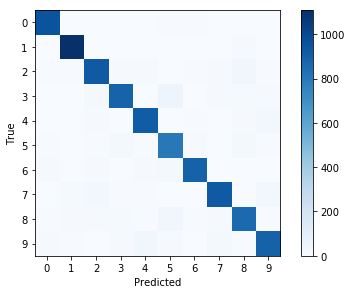

In [62]:
# Recurrimos a la función print_confusion_matrix() para obtener la matriz de confusión.
print_confusion_matrix()

Podemos cerrar la sesión una vez hayamos terminado nuestro análisis.

In [ ]:
session.close()